In [1]:
import inspect
import math
import os
import warnings

#import arviz as az

import jax.numpy as jnp
from jax import lax, ops, random

import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro.diagnostics import print_summary
from numpyro.infer import MCMC, NUTS, SVI, Trace_ELBO, init_to_value, Predictive
from numpyro.infer.autoguide import AutoLaplaceApproximation

import arviz

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from scipy.stats import beta
%matplotlib inline

## 5 Bayesian: A love story

We are taking this model from [this blog post](https://medium.com/paper-club/understanding-pyros-model-and-guide-a-love-story-7f3aa0603886) and translating it over to numpyro from pyro. 

Basic setup of the story:

* There are three friends that take turns paying for lunch
* The draws are supposed to be uniform (1/3, 1/3, 1/3)
* After collecting data, the article wants to do a hypothesis test -- are the probabilitiese equal

In [2]:
def model(data):
    a,b,c = 5,5,5
    pay_probs = numpyro.sample('pay_probs', dist.Dirichlet(np.array([a,b,c])))
    with numpyro.plate('data_loop', len(data)):
        return numpyro.sample('obs', dist.Categorical(probs=pay_probs), obs=data)

Specicifcally, we are intested in what the vector pay_probs is. Let's define the chain:

In [3]:
mcmc = MCMC(NUTS(model), num_warmup=500, num_samples=2500, num_chains=1)

## Scenario 1: 5 meals, person 1 (index 0) pays for 5 meals

In [4]:
data_scenario1 = np.array([0] * 5)

In [5]:
mcmc.run(random.PRNGKey(0), data=data_scenario1)

sample: 100%|██████████| 3000/3000 [00:05<00:00, 544.86it/s, 3 steps of size 9.90e-01. acc. prob=0.90]


In [6]:
mcmc.print_summary()


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
pay_probs[0]      0.50      0.11      0.50      0.34      0.69   1913.71      1.00
pay_probs[1]      0.25      0.09      0.24      0.10      0.39   2115.10      1.00
pay_probs[2]      0.25      0.09      0.24      0.09      0.39   2040.44      1.00

Number of divergences: 0


## Scenario 2: 50 meals, person 1 (index 0) pays for all

In [7]:
data_scenario2 = np.array([0] * 50)
mcmc.run(random.PRNGKey(0), data=data_scenario2)
mcmc.print_summary()

sample: 100%|██████████| 3000/3000 [00:05<00:00, 556.46it/s, 3 steps of size 7.98e-01. acc. prob=0.93]



                  mean       std    median      5.0%     95.0%     n_eff     r_hat
pay_probs[0]      0.85      0.05      0.85      0.78      0.92   1737.29      1.00
pay_probs[1]      0.08      0.03      0.07      0.03      0.13   1844.67      1.00
pay_probs[2]      0.08      0.03      0.07      0.02      0.12   1798.31      1.00

Number of divergences: 0


## Scenario 3: 50 meals, person 1 pays 30, person 2 pays 15, person 3 pays 5

In [8]:
data_scenario3 = np.array([0]*30 + [1]*15 + [2]*5)
mcmc.run(random.PRNGKey(0), data=data_scenario3)
mcmc.print_summary()

sample: 100%|██████████| 3000/3000 [00:05<00:00, 551.13it/s, 3 steps of size 8.77e-01. acc. prob=0.91]



                  mean       std    median      5.0%     95.0%     n_eff     r_hat
pay_probs[0]      0.54      0.06      0.54      0.45      0.65   2481.37      1.00
pay_probs[1]      0.31      0.06      0.31      0.21      0.39   2206.28      1.00
pay_probs[2]      0.15      0.04      0.15      0.08      0.22   2009.37      1.00

Number of divergences: 0


## Focus on results with scenario 3

Let's use the sample of the posterior distribution to get our distribution of what we think the probabilities are

In [9]:
# Sample the probabilities from the chain by getting first 5 runs
mcmc.get_samples()['pay_probs'][:5 ,:]

DeviceArray([[0.54328454, 0.348791  , 0.10792445],
             [0.52965343, 0.2814414 , 0.18890518],
             [0.52965343, 0.2814414 , 0.18890518],
             [0.5395693 , 0.35601825, 0.10441244],
             [0.5024087 , 0.38344777, 0.11414355]], dtype=float32)

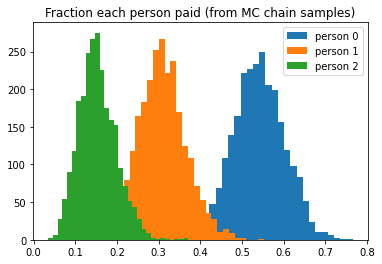

In [10]:
# Let's make a histogram of the probabilities from the samples in the chain
ax = plt.hist(mcmc.get_samples()['pay_probs'][:, 0], bins=30, label='person 0');
plt.hist(mcmc.get_samples()['pay_probs'][:, 1], bins=30, label='person 1');
plt.hist(mcmc.get_samples()['pay_probs'][:, 2], bins=30, label='person 2');
plt.legend();
plt.title('Fraction each person paid (from MC chain samples)');

## Do it again, but with guides

Guides allow us to more rapidly converge on the parameters (but we neede a parameteric description of what we think the final solution looks like). This is a trade-off: we get speed, but we lose the flexibility to fit distributions that we are not anticipating.

In [11]:
def guide(data=None):
    priors = numpyro.param("priors", jnp.array([5,5,5]), constraint=dist.constraints.positive)
    pay_probs = numpyro.sample('pay_probs', dist.Dirichlet(priors))

Let's solve using gradient descent (instead of MonteCarlo Markov Chain):

In [12]:
optimizer = numpyro.optim.Adam(step_size=0.05)
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

svi_result = svi.run(random.PRNGKey(0), 2000, data=data_scenario3)

100%|██████████| 2000/2000 [00:03<00:00, 633.04it/s, init loss: 77.8202, avg. loss [1901-2000]: 48.9030] 


Now make a predictive model. The guide allows us to do gradient descent and find the parameters, but we also hav to pass the parameters in (we do this using `params=svi_result.params`)

In [13]:
predictive = Predictive(model=model, 
                        guide=guide, 
                        params=svi_result.params, 
                        num_samples=6000,
                        return_sites=['pay_probs', 'obs'])

In [14]:
# Okay, lets generate new data NOT using the MCMC using the data in scenario 3
generated_observations = predictive(rng_key=random.PRNGKey(1), data=data_scenario3)

In [15]:
svi_result.params

{'priors': DeviceArray([32.11033 , 18.65016 ,  9.577283], dtype=float32)}

In [16]:
# Note that "obs" is just a copy of the observational data we put in
generated_observations

{'obs': DeviceArray([[0, 0, 0, ..., 2, 2, 2],
              [0, 0, 0, ..., 2, 2, 2],
              [0, 0, 0, ..., 2, 2, 2],
              ...,
              [0, 0, 0, ..., 2, 2, 2],
              [0, 0, 0, ..., 2, 2, 2],
              [0, 0, 0, ..., 2, 2, 2]], dtype=int32),
 'pay_probs': DeviceArray([[0.55314857, 0.27000886, 0.17684253],
              [0.5616581 , 0.29624367, 0.1420983 ],
              [0.66025287, 0.172514  , 0.16723315],
              ...,
              [0.50225776, 0.30359986, 0.19414233],
              [0.5507777 , 0.31346777, 0.13575463],
              [0.57796997, 0.24305525, 0.17897479]], dtype=float32)}

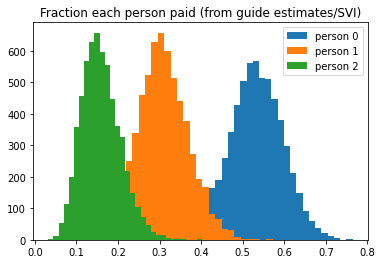

In [17]:
plt.hist(generated_observations['pay_probs'][:, 0], bins=30, label='person 0');
plt.hist(generated_observations['pay_probs'][:, 1], bins=30, label='person 1');
plt.hist(generated_observations['pay_probs'][:, 2], bins=30, label='person 2');
plt.legend();
plt.title('Fraction each person paid (from guide estimates/SVI)');